In [1]:
import numpy as np
import scipy.sparse as sp
from mpl_toolkits import mplot3d
from rom_am import ROM, EDMD, DMD
import matplotlib.pyplot as plt
import scipy.interpolate as si

We model here a non linear elastic spring, with its stiffnes law:
$$
m_p \ddot{u}(t) = k (L(t) - L_{s0}) + \mu (L(t) - L_0) + A p(t)
$$

Where $L(t) = L_{se} - L_0$

we can thus write the acceleration $\ddot u = \dot v$ and the nonlinear ODE system as:
$$
(ODE1) : \pmb{\dot{y}} = 
\begin{pmatrix}
\dot{u}(t)  \\
\dot{v}(t)  \\
\end{pmatrix} = \begin{pmatrix}
{v}(t)  \\
a u(t) + b u(t)^2 + c u(t)^3 + d(t)\\
\end{pmatrix} = f(\pmb{y}, t)$$
with
$a = \frac{K}{m_p} -  \frac{3\mu u_0²}{m_p}$
$b = \frac{3\mu u_0}{m_p}$
$c = -\frac{\mu}{m_p}$


$d(t) = \frac{\mu}{m_p}u_0³ + \frac{K}{m_p}u_0 + \frac{A}{m_p}p(t) = d_1 + d_2 * p(t)$
and 
$u_0 = L_{se} - L_{0}$
The notation is matching that used in ([E.Lefrançois and J-P, Boufflet, 2010](https://doi.org/10.1137/090758313))

## Creating the data : We first consider a constant pressure load (p(t) = cte)

$$p = 100 000 Pa$$ $$ d(t) = d$$

We first create the data by obtaining the solution ( snapshots) of $\pmb{y}$ through numerical integration using `scipy.integrate.solve_ivp` (MATLAB's `ode45`-like)

In [2]:
def create_data(pres, freq=0):
    mass = 1000
    rigid = 1e7
    mu_coeff = 6
    mu = mu_coeff * rigid / 0.2
    A = 1
    pres_init0 = 1e5
    Ls0 = 1.2
    L0 = 1
    if freq:
        p = lambda t : pres * np.sin(2 * np.pi * freq * t)
    else:
        p = lambda t : pres

    a_ = rigid;
    b_ = mu;
    c_ = A * pres_init0;
    interm = (((np.sqrt((27 * b_ * c_**2 + 4 * a_**3) / b_)) / (b_ * 2 * 3**(3. / 2.))) - c_ / (2 * b_))**(1. / 3.);
    u0 = interm - a_ / (3 * b_ * interm);

    a = -rigid/mass - 3*mu*(u0**2)/mass
    b = 3*mu*u0/mass
    c = -mu/mass
    d1 = (u0**3)*mu/mass + rigid * u0/mass 
    d2 = A/mass
    d = lambda t : d1 + d2 * p(t)
    model_param = lambda t : np.array([a, b, c, d(t), d1, d2])
    v_dot = lambda u, t : c * u**3 + b * u**2 + a * u + d(t)

    ntt = 600
    dt = 6e-4
    input_t = np.arange(ntt)*dt

    from scipy.integrate import solve_ivp
    def f(t, y): return np.array([y[1], v_dot(y[0], t)])
    sol = solve_ivp(f, [0, input_t[-1]], np.array([(Ls0 - L0), 0]), t_eval = input_t)
    input_data = sol.y.copy()
    
    return input_data, input_t,dt, v_dot, model_param

input_data, input_t, dt, v_dot, model_param = create_data(1e6)

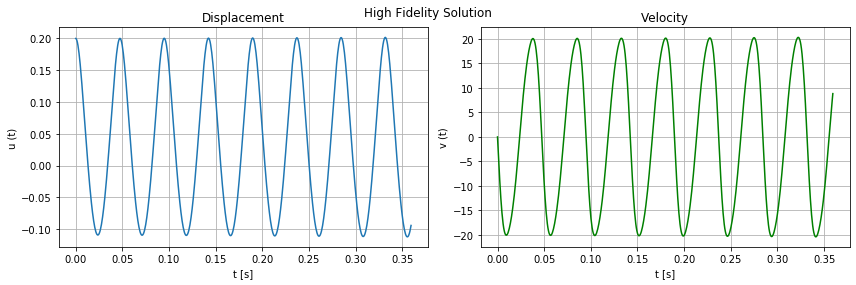

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(input_t, input_data[0, :],);
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("u (t)");
ax[0].set_title("Displacement");

ax[1].plot(input_t, input_data[1, :], 'g');
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel("v (t)");
ax[1].set_title("Velocity");

plt.tight_layout();
fig.suptitle("High Fidelity Solution");

In [4]:
Coeff = 0.7
train_data = input_data[:, :int(Coeff*input_data.shape[1])]
train_t = input_t[:int(Coeff*input_t.shape[0])]

test_data = input_data[:, int(Coeff*input_data.shape[1])::]
test_t = input_t[int(Coeff*input_t.shape[0])::]

X = train_data[:, :-1].reshape((2, -1))
Y = train_data[:, 1::].reshape((2, -1))

dmd = DMD()
drom = ROM(dmd)
drom.decompose(X,  Y = Y, dt = dt, normalize = True)

In [5]:
pred_t = input_t.copy()
pred = np.real(drom.predict(pred_t,))

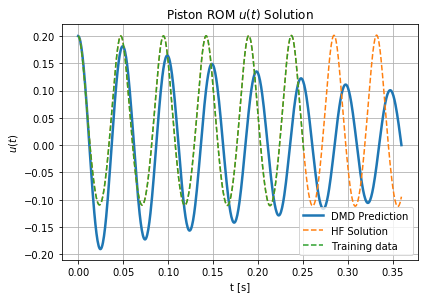

In [6]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, input_data[0, :], '--', label = 'HF Solution');
plt.plot(train_t[:-1], X[0, :], '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$u (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM $u (t)$ Solution"); 

In [7]:
Coeff = 0.7
train_data = input_data[:, :int(Coeff*input_data.shape[1])]
train_t = input_t[:int(Coeff*input_t.shape[0])]

test_data = input_data[:, int(Coeff*input_data.shape[1])::]
test_t = input_t[int(Coeff*input_t.shape[0])::]

X = train_data[:1, :-1].reshape((1, -1))
Y = train_data[:1, 1::].reshape((1, -1))

p = lambda t : 1e6 * np.ones(t.shape[0])
X = np.concatenate((X, p(train_t[:-1]).reshape((1, -1))))
Y = np.concatenate((Y, p(train_t[1::]).reshape((1, -1))))

dmd = DMD()
drom = ROM(dmd)
drom.decompose(X,  Y = Y, dt = dt, normalize = True)

In [8]:
pred_t = input_t.copy()
pred = np.real(drom.predict(pred_t,))

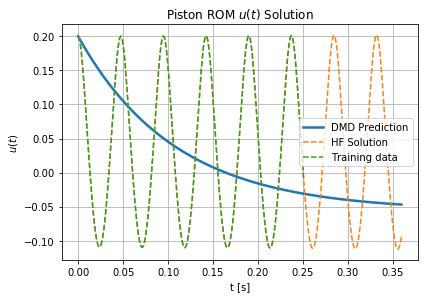

In [9]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, input_data[0, :], '--', label = 'HF Solution');
plt.plot(train_t[:-1], X[0, :], '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$u (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM $u (t)$ Solution"); 

In [10]:
X = train_data[:1, :-1].reshape((1, -1))
Y = train_data[:1, 1::].reshape((1, -1))

p = lambda t : 1e6 * np.ones(t.shape[0])
observables = {"X" : [lambda x : x, lambda x : x**2, lambda x : x**3, lambda x : np.ones((1, X.shape[1])), lambda x : p(train_t[:-1]).reshape((1, -1)), lambda x : v_dot(x, train_t[:-1])], 
               "Y" : [lambda x : x, lambda x : x**2, lambda x : x**3, lambda x : np.ones((1, X.shape[1])), lambda x : p(train_t[1::]).reshape((1, -1)), lambda x : v_dot(x, train_t[1::])]}

In [11]:
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, observables=observables)

/home/tiba/.local/lib/python3.8/site-packages/rom_am/edmd.py:159: RuntimeWarning: invalid value encountered in log
  omega = np.log(lambd) / dt  # Continuous system eigenvalues


In [12]:
pred_t = input_t.copy()
pred = np.real(drom.predict(pred_t,))

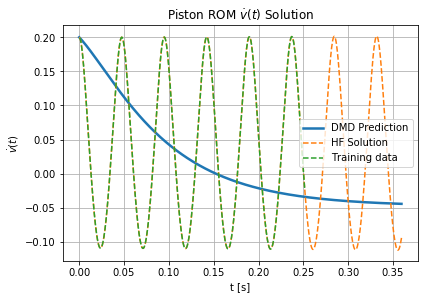

In [13]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, input_data[0, :], '--', label = 'HF Solution');
plt.plot(train_t[1::], Y[0, :], '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$\dot{v} (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM $\dot{v} (t)$ Solution");

In [14]:
data = np.zeros((6, 600))
data[:, 0] = np.array([0.2, 0.2**2, 0.2**3, 1, 1e6, v_dot(0, 0)])

for i in range(data.shape[1]-1):
    data[:, i+1] = edmd.A @ data[:, i].reshape((-1, 1))

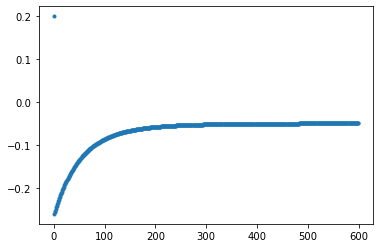

In [15]:
plt.plot(data[0, :], '.');

In [200]:
Coeff = 0.7
train_data = input_data[:, :int(Coeff*input_data.shape[1])]
train_t = input_t[:int(Coeff*input_t.shape[0])]

test_data = input_data[:, int(Coeff*input_data.shape[1])::]
test_t = input_t[int(Coeff*input_t.shape[0])::]

X = train_data[:1, :-1].reshape((1, -1))
Y = train_data[:1, 1::].reshape((1, -1))

p = lambda t : 1e6 * np.ones(t.shape[0])
X = np.concatenate((X, X**2, X**3, p(train_t[:-1]).reshape((1, -1)), np.ones((1, X.shape[1]))))
Y = np.concatenate((Y, Y**2, Y**3, p(train_t[1::]).reshape((1, -1)), np.ones((1, X.shape[1]))))

dmd = DMD()
drom = ROM(dmd)
drom.decompose(X,  Y = Y, dt = dt, normalize = True)

In [201]:
pred_t = input_t.copy()
pred = np.real(drom.predict(pred_t,))

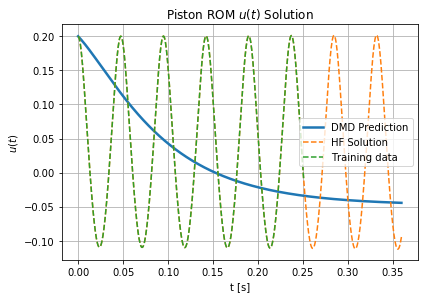

In [202]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, input_data[0, :], '--', label = 'HF Solution');
plt.plot(train_t[:-1], X[0, :], '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$u (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM $u (t)$ Solution"); 

**Organizing training data**

We will train our ROM on snapshots of $$
\pmb{X} = 
\begin{pmatrix}
u^k  \\
(u^k)²  \\
(u^k)^3  \\
1  \\
\end{pmatrix} and \; \pmb{Y} = \begin{pmatrix}
\dot{v}^k  \\
\end{pmatrix}$$

We thus expect from the ROM to learn the model parameters:
$$ \pmb{A} = 
\begin{pmatrix}
a & b & c & d
\end{pmatrix}
$$


In [4]:
Coeff = 0.7
train_data = input_data[:, :int(Coeff*input_data.shape[1])]
train_t = input_t[:int(Coeff*input_t.shape[0])]

test_data = input_data[:, int(Coeff*input_data.shape[1])::]
test_t = input_t[int(Coeff*input_t.shape[0])::]

X = train_data[:1, :].reshape((1, -1))
Y = train_data[:1, :].reshape((1, -1))

observables = {"X" : [lambda x : x, lambda x : x**2, lambda x : x**3, lambda x : np.ones((1, X.shape[1]))], 
               "Y" : [lambda x : v_dot(x, train_t)]}

**Extended DMD learns:**

In [5]:
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, observables = observables)

The DMD operator is $\pmb{A}$ = 

In [6]:
edmd.A

array([[ -10089.46559813,   -8973.24012361, -299999.99999951,
            900.        ]])

and **[a, b, c, d]** for this case is

In [7]:
model_param(0)[:-2]

array([ -10089.46559813,   -8973.24012351, -300000.        ,
           900.        ])

**eDMD did indeed learn the model parameters precisely.**

**Extended DMD predicts:**

In [8]:
pred_t = input_t.copy()
input_ = np.vstack((input_data[0, :], input_data[0, :]**2, input_data[0, :]**3, np.ones((1,len(pred_t)))))
pred = np.real(drom.predict(pred_t, x_input = input_))

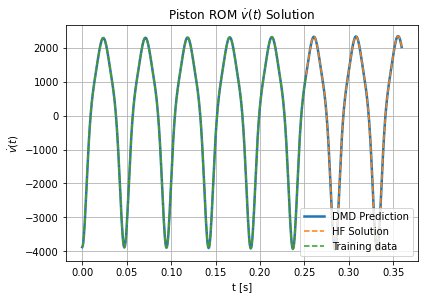

In [9]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, v_dot(input_data[0, :], input_t), '--', label = 'HF Solution');
plt.plot(train_t, v_dot(Y[0, :], train_t), '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$\dot{v} (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM $\dot{v} (t)$ Solution"); 

-----------------------------------------------------------------------------------------------------------------------------

## Unsteady pressure load p(t)

$$ p(t) = 10^6 sin(2\pi f_f t)$$
with $f_f$ is the frequency of the pressure load (In the context of the piston/gas test case, it represents the pressure wave frequency).
Choosing $f_f = 20 Hz$ creates a strong coupling between the springsystem and the exterior load, because it's close to the spring natural frequency (see the displacement plot)

In [10]:
input_data, input_t, dt, v_dot, model_param = create_data(1e6, 20)

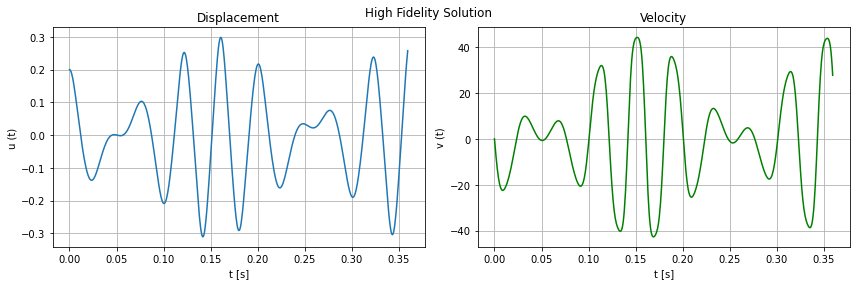

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(input_t, input_data[0, :],);
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("u (t)");
ax[0].set_title("Displacement");

ax[1].plot(input_t, input_data[1, :], 'g');
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel("v (t)");
ax[1].set_title("Velocity");

plt.tight_layout();
fig.suptitle("High Fidelity Solution");

In [12]:
Coeff = 0.7
train_data = input_data[:, :int(Coeff*input_data.shape[1])]
train_t = input_t[:int(Coeff*input_t.shape[0])]

test_data = input_data[:, int(Coeff*input_data.shape[1])::]
test_t = input_t[int(Coeff*input_t.shape[0])::]

X = train_data[:1, :].reshape((1, -1))
Y = train_data[:1, :].reshape((1, -1))

observables = {"X" : [lambda x : x, lambda x : x**2, lambda x : x**3, lambda x : np.ones((1, X.shape[1]))], 
               "Y" : [lambda x : v_dot(x, train_t)]}

**eDMD learning:** At first we consider the same set of observables : 

$$
\pmb{X} = 
\begin{pmatrix}
u^k  \\
(u^k)²  \\
(u^k)^3  \\
1  \\
\end{pmatrix} and \; \pmb{Y} = \begin{pmatrix}
\dot{v}^k  \\
\end{pmatrix}$$

In [13]:
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, observables=observables)

In [14]:
pred_t = input_t.copy()
input_ = np.vstack((input_data[0, :], input_data[0, :]**2, input_data[0, :]**3, np.ones((1,len(pred_t)))))
pred = np.real(drom.predict(pred_t, x_input = input_))

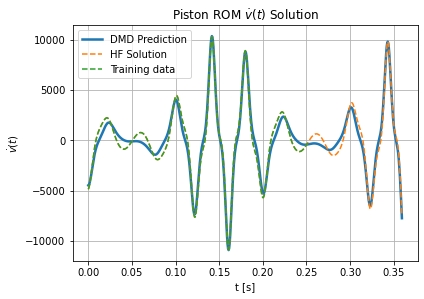

In [15]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, v_dot(input_data[0, :], input_t), '--', label = 'HF Solution');
plt.plot(train_t, v_dot(Y[0, :], train_t), '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$\dot{v} (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM $\dot{v} (t)$ Solution"); 

**Add the pressure to the set of observables** : We consider now

$$
\pmb{X} = 
\begin{pmatrix}
u^k  \\
(u^k)²  \\
(u^k)^3  \\
1  \\
p^k \\
\end{pmatrix} and \; \pmb{Y} = \begin{pmatrix}
\dot{v}^k  \\
\end{pmatrix}$$

In [16]:
X = train_data[:1, :].reshape((1, -1))
Y = train_data[:1, :].reshape((1, -1))

p = lambda t : 1e6 * np.sin(2 * np.pi * 20 * t)
observables = {"X" : [lambda x : x, lambda x : x**2, lambda x : x**3, lambda x : np.ones((1, X.shape[1])), lambda x : p(train_t).reshape((1, -1))], 
               "Y" : [lambda x : v_dot(x, train_t)]}

In [17]:
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, observables=observables)

In [18]:
pred_t = input_t.copy()
input_ = np.vstack((input_data[0, :], input_data[0, :]**2, input_data[0, :]**3, np.ones((1,len(pred_t))), p(input_t).reshape((1, -1))))
pred = np.real(drom.predict(pred_t, x_input = input_))

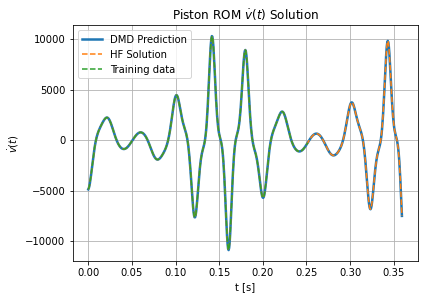

In [19]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, v_dot(input_data[0, :], input_t), '--', label = 'HF Solution');
plt.plot(train_t, v_dot(Y[0, :], train_t), '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$\dot{v} (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title(r"Piston ROM $\dot{v} (t)$ Solution"); 

We notice an enhanced ROM solution. If we show the learned eDMD operator:

$\pmb{A} = $

In [20]:
edmd.A

array([[-1.00894656e+04, -8.97324021e+03, -3.00000000e+05,
        -9.99999984e+01,  1.00000000e-03]])

and **[a, b, c, $\pmb{d_1}$, $\pmb{d_2}$]** = 

In [21]:
model_param(0)[[0, 1, 2, 4, 5]]

array([-1.00894656e+04, -8.97324012e+03, -3.00000000e+05, -1.00000000e+02,
        1.00000000e-03])

With the learned model, and the predicted $v^k$ values, we can solve (ODE1) (See the first system) in order to compute $u^k$ values. Alternatively, for this case, Quasi-Newton schemes can be appplied to compute $u^k$ : 

In [22]:
import scipy.optimize as op

def fun(x, param_):
    return v_dot(x, param_) - pred[0, :]

res = op.newton(fun, np.zeros(pred[0, :].shape), args = (pred_t, ))

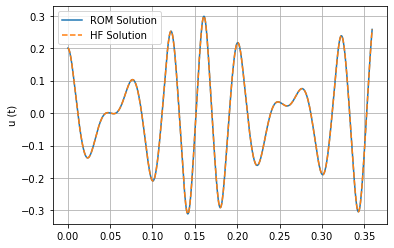

In [23]:
plt.plot(pred_t, res, label = 'ROM Solution');
plt.plot(input_t, input_data[0, :], '--', label = 'HF Solution');
plt.grid();
plt.ylabel("u (t)");
plt.legend();